Number of training frames = 27712
Number of sparse training frames = 21988
{'normed': True, 'range': (-1.0, 1.0), 'bins': 51}


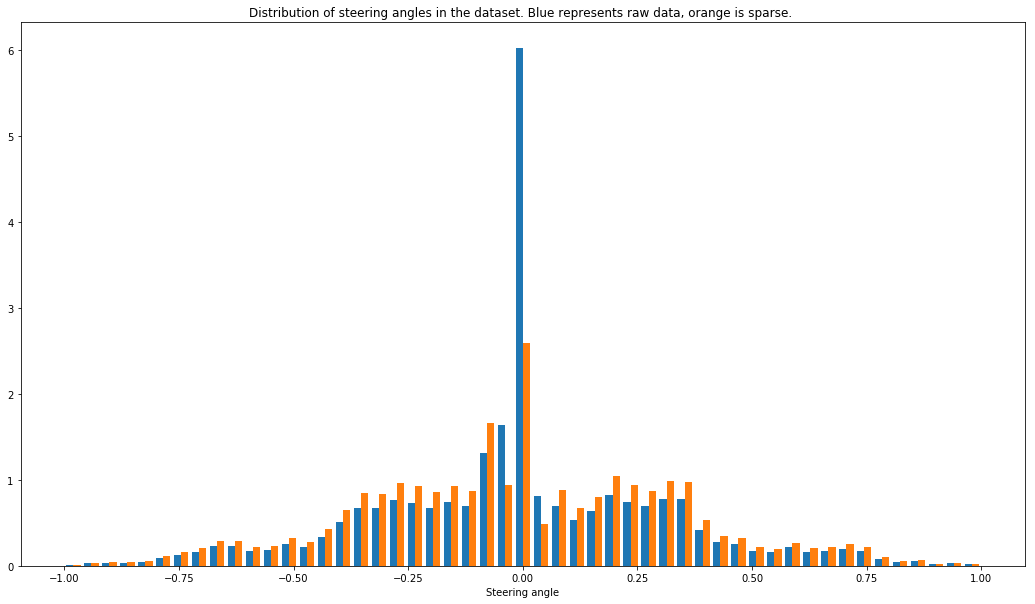

In [8]:
import os
import csv
from random import shuffle, randint
import matplotlib.pyplot as plt


samples = []
with open('./data/driving_log-working.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)


angle_dist=[]
for i in range(len(samples)):
    angle_dist.append(float(samples[i][3]))
#plot_histogram(angle_dist,'steering angle distribution.png')

sparse_samples=[]
for sample in samples:
    if abs(float(sample[3]))> 0.05:
        sparse_samples.append(sample)
    elif randint(0,2)==0:
        sparse_samples.append(sample)

sparse_dist=[]
for i in range(len(sparse_samples)):
    sparse_dist.append(float(sparse_samples[i][3]))

#plot_histogram(sparse_dist,'steering angle distribution.png')

print("Number of training frames =", len(samples))
print("Number of sparse training frames =", len(sparse_samples))

def plot_histogram(name):
    plt.figure(figsize=(18,10))
    common_params = dict(bins=51, range=(-1.,1.),normed=True)
    print(common_params)
    plt.title('Distribution of steering angles in the dataset. Blue represents raw data, orange is sparse. ')
    plt.hist((angle_dist, sparse_dist), **common_params)
    plt.xlabel("Steering angle")
    plt.savefig(name)
    plt.show()
plot_histogram('steering_angles.png')



Epoch 1/10
17590/17590 [==============================] - 114s - loss: 0.0784 - val_loss: 0.0513
Epoch 2/10
17590/17590 [==============================] - 103s - loss: 0.0450 - val_loss: 0.0397
Epoch 3/10
17590/17590 [==============================] - 101s - loss: 0.0356 - val_loss: 0.0294
Epoch 4/10
17590/17590 [==============================] - 103s - loss: 0.0286 - val_loss: 0.0253
Epoch 5/10
17590/17590 [==============================] - 101s - loss: 0.0276 - val_loss: 0.0231
Epoch 6/10
17590/17590 [==============================] - 101s - loss: 0.0242 - val_loss: 0.0200
Epoch 7/10
17590/17590 [==============================] - 102s - loss: 0.0228 - val_loss: 0.0192
Epoch 8/10
17590/17590 [==============================] - 97s - loss: 0.0209 - val_loss: 0.0208
Epoch 9/10
17590/17590 [==============================] - 100s - loss: 0.0190 - val_loss: 0.0161
Epoch 10/10
17590/17590 [==============================] - 106s - loss: 0.0178 - val_loss: 0.0157
dict_keys(['val_loss', 'loss']

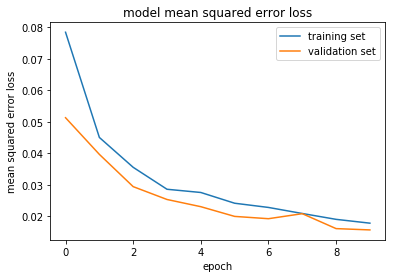

boarding complete


In [11]:

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(sparse_samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

def augment_img(image,angle):
    #randomly flip images 
    if randint(0,1)==1:
        image=cv2.flip(image,1)
        angle*=-1.
    if True:
        #convert every second frame to hsv and apply random brightness
        image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
        image1 = np.array(image1, dtype = np.float64)
        random_bright = .5+np.random.uniform()
        image1[:,:,2] = image1[:,:,2]*random_bright
        image1[:,:,2][image1[:,:,2]>255]  = 255
        image1 = np.array(image1, dtype = np.uint8)
        image = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
#    if True:
        h, w = image.shape[0], image.shape[1]
        [x1, x2] = np.random.choice(w, 2, replace=False)
        k = h / (x2 - x1)
        b = - k * x1
        for i in range(h):
            c = int((i - b) / k)
            image[i, :c, :] = (image[i, :c, :] * .5).astype(np.int32)
    return image, angle

def generator(samples, batch_size=196):
    num_samples = len(samples)
    correction_factor = 0.2
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                    #choose random camera
                    camera=randint(0,2)
                    name = './data/IMG/'+batch_sample[camera].split('/')[-1]
                    #print(name)
                    #convert image to RGB like the simulator 
                    image = cv2.cvtColor(cv2.imread(name),cv2.COLOR_BGR2RGB)
                    angle = float(batch_sample[3])
                    #left image gets more steering angle
                    if camera==1:
                         angle+=correction_factor
                    #right image gets less steering angle
                    elif camera == 2:
                         angle-=correction_factor 
                    image, angle = augment_img(image,angle)
                    images.append(image)
                    angles.append(angle)
                    
            X_train = np.array(images)
            y_train = np.array(angles)
            
            #print(X_train.shape)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=196)
validation_generator = generator(validation_samples, batch_size=196)

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, MaxPooling2D, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
#modified LeNet
if False:
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((50,20),(0,0))))
    model.add(Convolution2D(16,5,5,activation="elu"))
    model.add(MaxPooling2D())
    model.add(Convolution2D(64,5,5,activation="elu"))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(240))
    model.add(Dropout(.5))
    model.add(Dense(120))
    model.add(Dropout(.5))
    model.add(Dense(1))
#modified NVIDIA model https://devblogs.nvidia.com/deep-learning-self-driving-cars/
if False:
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((50,20),(0,0))))
    #24@41*98
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid', activation="relu", init='orthogonal'))
    #36@14*47
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid', activation="relu", init='orthogonal'))
    #48@5*22
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='valid', activation="relu", init='orthogonal'))
    #64@3*20
    model.add(Convolution2D(64, 3, 3, border_mode='valid',activation="relu", init='orthogonal'))
    model.add(Dropout(.5))
    #64@1x18
    model.add(Convolution2D(64, 3, 3, border_mode='valid',activation="relu", init='orthogonal'))
    model.add(Dropout(.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', init='orthogonal'))
    model.add(Dropout(.5))
    model.add(Dense(48, activation='relu', init='orthogonal'))
    model.add(Dropout(.5))
    model.add(Dense(10, activation='relu', init='orthogonal'))
    model.add(Dense(1))


#commaai model
if True:
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((50,20),(0,0))))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same", activation="relu", init='orthogonal'))
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same", activation="relu", init='orthogonal'))
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same", activation="relu", init='orthogonal'))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(Dense(512,activation="relu", init='orthogonal'))
    model.add(Dropout(.5))
    model.add(Dense(50,activation="relu", init='orthogonal'))
    model.add(Dense(1))



model.compile(loss='mse', optimizer='adam')


from keras.models import Model
import matplotlib.pyplot as plt

history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples), validation_data = 
    validation_generator,
    nb_val_samples = len(validation_samples), 
    nb_epoch=10, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

plt.figure()
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
model.save('model_2.h5')
print('boarding complete')



./data/IMG/center_2018_03_17_15_51_45_379.jpg
./data/IMG/center_2018_03_17_16_06_33_207.jpg
./data/IMG/center_2018_03_17_16_01_18_420.jpg


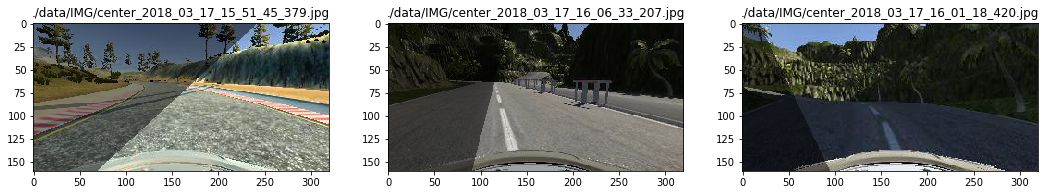

In [10]:
### Data exploration visualization code 
import random
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def plot_frames():
    plt.figure(figsize=(18,10))
    n_col = 3
    for column in range(1,n_col+1):
        index= random.randint(0, len(samples))
        name = './data/IMG/'+samples[index][0].split('/')[-1]
        print(name)
        image = cv2.cvtColor(cv2.imread(name),cv2.COLOR_BGR2RGB)
        image, angle = augment_img(image,0)
        plt.subplot(2, n_col, column+n_col)
        fig=plt.title(name)
        fig=plt.imshow(image)
        #plt.imsave(str(y_train[index]) +".png", image)
        fig.figure.savefig("random-frames.png")
plot_frames()